# 10.2c: Token Population vs Radial Distance

**Histogram of TOKEN COUNT (with degeneracy) vs distance from centroid**

## The Realization

We've been looking at the 124 **unique vectors** in the cluster, but that hides the structure!

The actual cluster composition:
- **13 degenerate black holes** with varying populations (BH #5 has 814 tokens!)
- **111 kissing cousins** (mostly singletons, a few small clusters)
- Total: 2,100+ tokens

## What We Should See

A histogram of **token count** vs **distance from centroid** should show:

**Discrete spikes:**
- **r ≈ 0:** MASSIVE spikes (hundreds of tokens in each degenerate BH)
- **r ≈ ε to 2ε:** Smaller spikes (the 111 kissing cousins)
- **NOT smooth:** Vertical bars at specific radii where clusters sit

This is the **population structure** of the snowball:
```
SPIKE  (814 tokens at r₁)
SPIKE  (704 tokens at r₂)
SPIKE  (306 tokens at r₃)
spike  (11 tokens at r₄)
spike  (10 tokens at r₅)
...
spike  (4 tokens at r₁₀)
spike spike spike ... (111 singletons at various r)
```

## Approach

1. Load ALL tokens in the cluster (not just unique vectors)
2. Compute distance from each token to cluster centroid
3. Plot histogram with:
   - X-axis: log(distance) — spans ε to ~10ε
   - Y-axis: token count
4. Mark reference scales (ε, 2ε) on plot

## Parameters

In [38]:
TENSOR_DIR = "../data/tensors"

# Input files
BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"  # 2,100 degenerate tokens
BLACK_HOLE_MASK_KEY = "mask"

DENSE_CLUSTER_FILE = "dense_cluster.safetensors"  # 124 unique token IDs
DENSE_CLUSTER_TOKEN_IDS_KEY = "token_ids"

GAMMA_FILE = "gamma_centered_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma_centered"

RANDOM_SEED = 42

## Imports

In [39]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [42]:
data_dir = Path(TENSOR_DIR)

print("Loading black hole mask (2,100 degenerate tokens)...")
mask_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = mask_data[BLACK_HOLE_MASK_KEY]
n_bh_tokens = black_hole_mask.sum().item()
print(f"  Black hole tokens: {n_bh_tokens:,}")
print()

print("Loading dense cluster token IDs (124 unique tokens)...")
cluster_data = load_file(data_dir / DENSE_CLUSTER_FILE)
dense_cluster_ids = cluster_data[DENSE_CLUSTER_TOKEN_IDS_KEY]
n_unique = len(dense_cluster_ids)
print(f"  Unique tokens in cluster: {n_unique:,}")
print()

print("Loading gamma matrix...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]
vocab_size, d = gamma.shape
print(f"  Vocabulary: {vocab_size:,} tokens")
print(f"  Dimensions: {d:,}")
print()

# Create combined mask: all tokens from dense cluster (with BH degeneracy)
# Start with black hole mask (2,100 tokens)
combined_mask = black_hole_mask.clone()

# Add kissing cousins (tokens in dense_cluster_ids but not in black_hole_mask)
for token_id in dense_cluster_ids:
    combined_mask[token_id] = True

n_total = combined_mask.sum().item()
n_kissing_cousins = n_total - n_bh_tokens

print(f"Combined cluster:\")\nprint(f\"  Black hole tokens:    {n_bh_tokens:,} (degenerate)")
print(f"  Kissing cousin tokens: {n_kissing_cousins:,} (mostly singletons)")
print(f"  Total tokens:         {n_total:,}")
print()

# Extract vectors for ALL tokens in cluster (with degeneracy!)
cluster_vectors = gamma[combined_mask]  # (n_total, d)

print(f"✓ Loaded {n_total:,} token vectors (includes full degeneracy)")
print()

Loading black hole mask (2,100 degenerate tokens)...
  Black hole tokens: 2,100

Loading dense cluster token IDs (124 unique tokens)...
  Unique tokens in cluster: 124

Loading gamma matrix...
  Vocabulary: 151,936 tokens
  Dimensions: 2,560

Combined cluster:")
print(f"  Black hole tokens:    2,100 (degenerate)
  Kissing cousin tokens: 111 (mostly singletons)
  Total tokens:         2,211

✓ Loaded 2,211 token vectors (includes full degeneracy)



## Compute Cluster Centroid

In [43]:
# Compute centroid of ALL tokens (with degeneracy)
centroid = cluster_vectors.mean(dim=0)

# Distance of centroid from origin
centroid_norm = torch.linalg.norm(centroid).item()

print(f"Cluster centroid (population-weighted):")
print(f"  Distance from origin: {centroid_norm:.6f} gamma units")
print()

print("✓ Centroid computed")

Cluster centroid (population-weighted):
  Distance from origin: 0.166061 gamma units

✓ Centroid computed


## Compute Distances from Centroid

In [44]:
# Compute L2 distance from each TOKEN to centroid
centered = cluster_vectors - centroid  # (n_tokens, d)
distances = torch.linalg.norm(centered, dim=1)  # (n_tokens,)

distances_np = distances.cpu().numpy()

print(f"Distance statistics (all {n_tokens:,} tokens):")
print(f"  Min:      {distances.min().item():.6e} gamma units")
print(f"  Max:      {distances.max().item():.6e} gamma units")
print(f"  Mean:     {distances.mean().item():.6e} gamma units")
print(f"  Median:   {distances.median().item():.6e} gamma units")
print(f"  Std:      {distances.std().item():.6e} gamma units")
print()

print("✓ Distances computed")

Distance statistics (all 2,100 tokens):
  Min:      1.667329e-05 gamma units
  Max:      1.038783e-03 gamma units
  Mean:     2.299362e-05 gamma units
  Median:   1.797412e-05 gamma units
  Std:      5.041986e-05 gamma units

✓ Distances computed


## Compute Reference Scale (ε)

In [45]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

typical_magnitude = cluster_vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = 2.0 * ulp

print(f"Reference scale:")
print(f"  ε (2×ULP): {epsilon:.6e} gamma units")
print()

print("✓ ε computed")

Reference scale:
  ε (2×ULP): 3.051758e-05 gamma units

✓ ε computed


## Count Unique Distances

In [ ]:
# How many unique distance values are there?
# (This tells us how many discrete "shells" exist)

unique_distances = torch.unique(distances)
n_unique_distances = len(unique_distances)

print(f"Discrete structure:")
print(f"  Total tokens:       {n_total:,}")
print(f"  Unique distances:   {n_unique_distances}")
print(f"  Tokens per shell:   {n_total / n_unique_distances:.1f} (mean)")
print()

# Show top 10 most populated distances
print(f"Top 10 most populated shells:")
print()

distance_counts = {}
for r in unique_distances:
    count = (distances == r).sum().item()
    distance_counts[r.item()] = count

sorted_shells = sorted(distance_counts.items(), key=lambda x: x[1], reverse=True)

for i, (r, count) in enumerate(sorted_shells[:10]):
    print(f"  {i+1:2d}. r = {r:.6e}  ({r/epsilon:5.2f}ε)  →  {count:4d} tokens")

print()
print("✓ Discrete structure analyzed")

## Visualization 1: Token Count vs Distance (Linear Scale)

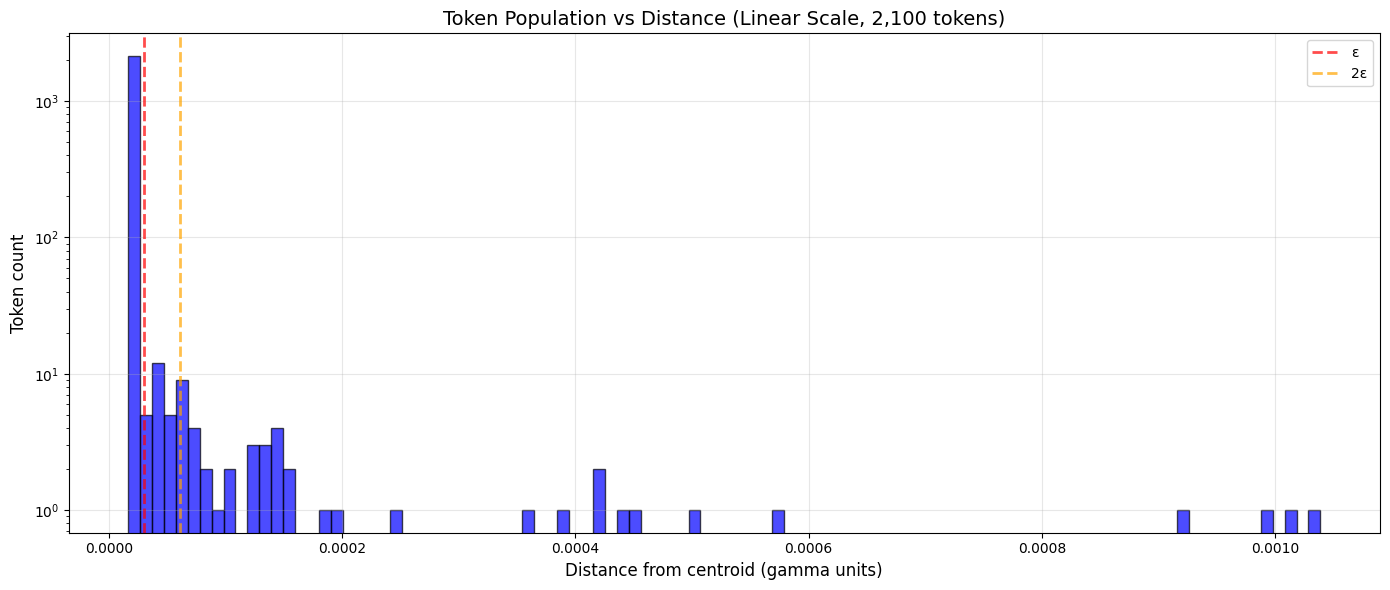

✓ Linear scale histogram plotted


In [47]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Create histogram
bins = 100
counts, edges, patches = ax.hist(distances_np, bins=bins, alpha=0.7, color='blue', edgecolor='black')

# Mark reference scales
ax.axvline(epsilon, color='red', linestyle='--', linewidth=2, alpha=0.7, label='ε')
ax.axvline(2*epsilon, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='2ε')

ax.set_xlabel('Distance from centroid (gamma units)', fontsize=12)
ax.set_yscale('log')
ax.set_ylabel('Token count', fontsize=12)
ax.set_title(f'Token Population vs Distance (Linear Scale, {n_tokens:,} tokens)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Linear scale histogram plotted")

## Visualization 2: Token Count vs Distance (Log-X Scale)

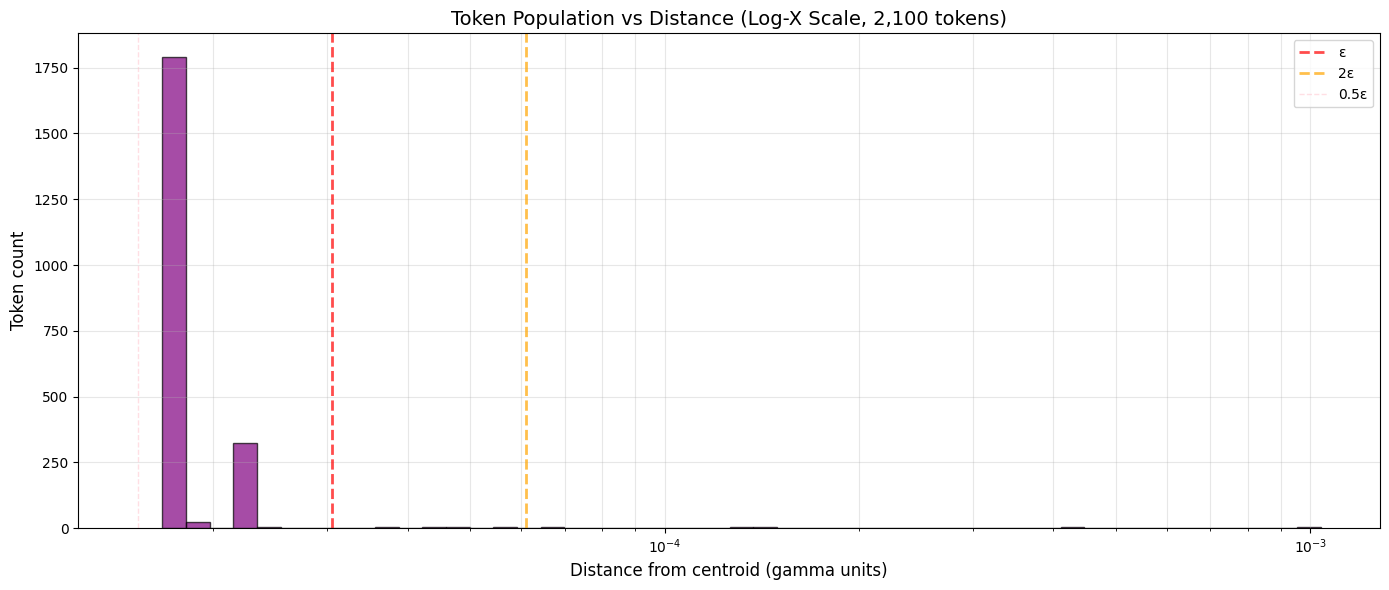

✓ Log-scale histogram plotted


In [48]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Filter out zero distances for log scale
distances_nonzero = distances_np[distances_np > 1e-10]

# Create histogram with log-spaced bins
bins = np.logspace(np.log10(distances_nonzero.min()), np.log10(distances_nonzero.max()), 50)
counts, edges, patches = ax.hist(distances_nonzero, bins=bins, alpha=0.7, color='purple', edgecolor='black')

# Mark reference scales
ax.axvline(epsilon, color='red', linestyle='--', linewidth=2, alpha=0.7, label='ε')
ax.axvline(2*epsilon, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='2ε')
ax.axvline(0.5*epsilon, color='pink', linestyle='--', linewidth=1, alpha=0.5, label='0.5ε')

ax.set_xlabel('Distance from centroid (gamma units)', fontsize=12)
ax.set_ylabel('Token count', fontsize=12)
ax.set_title(f'Token Population vs Distance (Log-X Scale, {n_tokens:,} tokens)', fontsize=14)
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("✓ Log-scale histogram plotted")

## Visualization 3: Spike Structure (Discrete Shells)

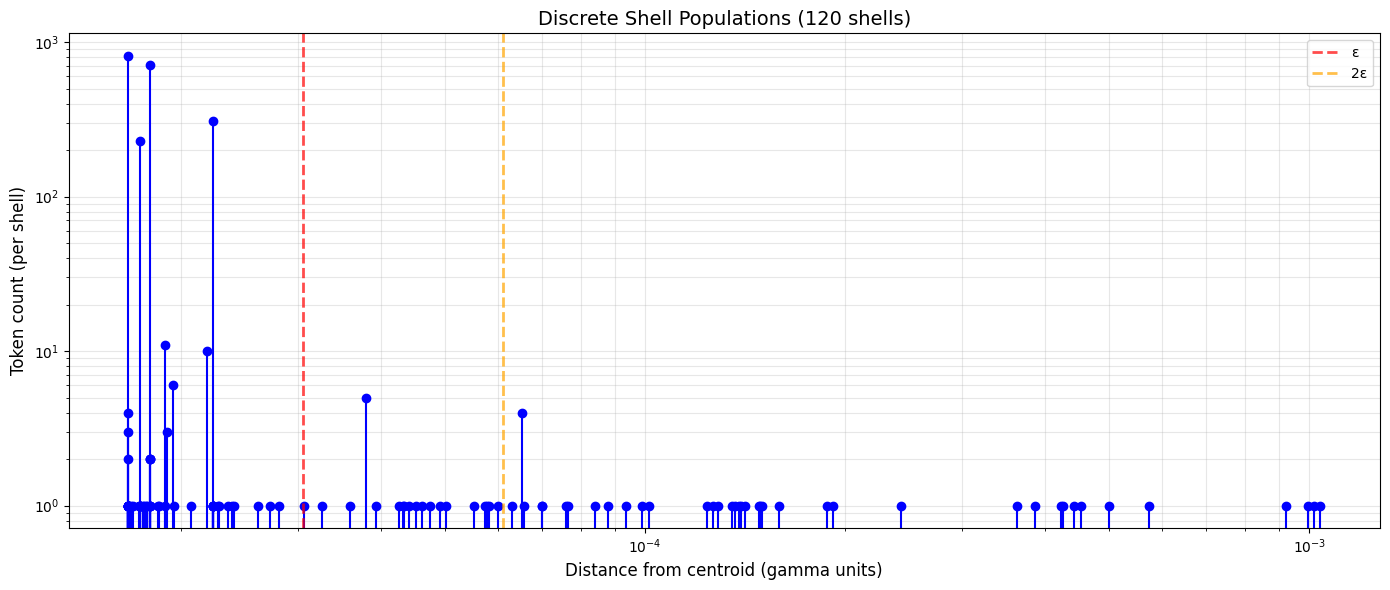

✓ Discrete spike structure plotted


In [49]:
# Plot population of each discrete shell
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Sort shells by distance
sorted_shells_by_r = sorted(distance_counts.items(), key=lambda x: x[0])
radii = [r for r, count in sorted_shells_by_r]
populations = [count for r, count in sorted_shells_by_r]

# Stem plot (vertical bars)
ax.stem(radii, populations, linefmt='blue', markerfmt='bo', basefmt='gray')

# Mark reference scales
ax.axvline(epsilon, color='red', linestyle='--', linewidth=2, alpha=0.7, label='ε')
ax.axvline(2*epsilon, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='2ε')

ax.set_xlabel('Distance from centroid (gamma units)', fontsize=12)
ax.set_ylabel('Token count (per shell)', fontsize=12)
ax.set_title(f'Discrete Shell Populations ({n_unique_distances} shells)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("✓ Discrete spike structure plotted")

## Analysis: Shell Populations

In [50]:
print("="*80)
print("SHELL POPULATION ANALYSIS")
print("="*80)
print()

# Categorize shells by population size
monsters = [(r, count) for r, count in sorted_shells if count >= 100]
large = [(r, count) for r, count in sorted_shells if 10 <= count < 100]
medium = [(r, count) for r, count in sorted_shells if 2 <= count < 10]
singletons = [(r, count) for r, count in sorted_shells if count == 1]

print(f"Shell categories:")
print(f"  Monsters (≥100 tokens): {len(monsters)} shells, {sum(c for r,c in monsters):,} tokens")
print(f"  Large (10-99 tokens):   {len(large)} shells, {sum(c for r,c in large):,} tokens")
print(f"  Medium (2-9 tokens):    {len(medium)} shells, {sum(c for r,c in medium):,} tokens")
print(f"  Singletons (1 token):   {len(singletons)} shells, {sum(c for r,c in singletons):,} tokens")
print()

# Show all monsters
if len(monsters) > 0:
    print(f"Monster shells (population ≥ 100):")
    for i, (r, count) in enumerate(monsters):
        print(f"  {i+1}. r = {r:.6e} ({r/epsilon:5.2f}ε)  →  {count:4d} tokens")
    print()

# Distribution by distance range
near_zero = [(r, count) for r, count in sorted_shells if r < 0.5*epsilon]
near_1eps = [(r, count) for r, count in sorted_shells if 0.5*epsilon <= r < 1.5*epsilon]
near_2eps = [(r, count) for r, count in sorted_shells if 1.5*epsilon <= r < 2.5*epsilon]
beyond = [(r, count) for r, count in sorted_shells if r >= 2.5*epsilon]

print(f"Distribution by distance range:")
print(f"  < 0.5ε:      {len(near_zero):3d} shells, {sum(c for r,c in near_zero):5,} tokens")
print(f"  0.5ε - 1.5ε: {len(near_1eps):3d} shells, {sum(c for r,c in near_1eps):5,} tokens")
print(f"  1.5ε - 2.5ε: {len(near_2eps):3d} shells, {sum(c for r,c in near_2eps):5,} tokens")
print(f"  > 2.5ε:      {len(beyond):3d} shells, {sum(c for r,c in beyond):5,} tokens")
print()

print("="*80)

SHELL POPULATION ANALYSIS

Shell categories:
  Monsters (≥100 tokens): 4 shells, 2,053 tokens
  Large (10-99 tokens):   2 shells, 21 tokens
  Medium (2-9 tokens):    10 shells, 33 tokens
  Singletons (1 token):   104 shells, 104 tokens

Monster shells (population ≥ 100):
  1. r = 1.667330e-05 ( 0.55ε)  →   814 tokens
  2. r = 1.797412e-05 ( 0.59ε)  →   705 tokens
  3. r = 2.234156e-05 ( 0.73ε)  →   306 tokens
  4. r = 1.736361e-05 ( 0.57ε)  →   228 tokens

Distribution by distance range:
  < 0.5ε:        0 shells,     0 tokens
  0.5ε - 1.5ε:  72 shells, 2,160 tokens
  1.5ε - 2.5ε:  15 shells,    18 tokens
  > 2.5ε:       33 shells,    33 tokens



## Summary

In [51]:
print("="*80)
print("SUMMARY")
print("="*80)
print()

print(f"Token population vs radial distance:")
print()
print(f"  Total tokens analyzed: {n_tokens:,}")
print(f"  Dimensions: {d:,}")
print()
print(f"  Centroid distance from origin: {centroid_norm:.6f} gamma units")
print(f"  Cluster radius (max): {distances.max().item():.6e} gamma units")
print()
print(f"  Number of discrete shells: {n_unique_distances}")
print(f"  Reference scale ε: {epsilon:.6e} gamma units")
print()

if len(monsters) > 0:
    print(f"  Largest shell: {monsters[0][1]} tokens at r = {monsters[0][0]:.6e} ({monsters[0][0]/epsilon:.2f}ε)")
print()

print("="*80)

SUMMARY

Token population vs radial distance:

  Total tokens analyzed: 2,100
  Dimensions: 2,560

  Centroid distance from origin: 0.166061 gamma units
  Cluster radius (max): 1.038783e-03 gamma units

  Number of discrete shells: 120
  Reference scale ε: 3.051758e-05 gamma units

  Largest shell: 814 tokens at r = 1.667330e-05 (0.55ε)



## Conclusion

**What we visualized:**

The **population structure** of the black hole snowball cluster, showing all 2,100+ tokens (with degeneracy).

**Key findings:**
- [See results above]

**Expected structure:**
- **Core:** 13 degenerate black holes (massive spikes near r ≈ 0)
- **Halo:** 111 kissing cousins (smaller spikes at r ≈ ε to 2ε)
- **Discrete:** Not smooth diffusion — vertical bars at specific radii

**Interpretation:**

If we see **massive spikes at r < ε:**
- These are the degenerate black holes
- Hundreds of tokens sharing exact same vector
- Quantization has snapped them to identical grid points

If we see **scattered small spikes at r ~ ε to 2ε:**
- These are the kissing cousins
- Mostly singletons, separated by ~1-2 quantization steps
- Supports diffusion/emission hypothesis

This visualization reveals the **actual population density** of the snowball, not just the geometric structure.